<a href="https://colab.research.google.com/github/PGPradhan/Lead-Scoring/blob/main/CRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# installlation required
!pip install Lifetimes
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00


In [3]:
# libraries
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [4]:
!pip install squarify

In [5]:
import squarify

In [6]:
 df = pd.read_csv("/content/demoCRM.csv", encoding='unicode_escape')

In [7]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df.shape

(156, 8)

In [8]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(df)

################ Shape ####################
(156, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
############### Types #####################
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID      int64
Country         object
dtype: object
############### Head ######################
  Invoice StockCode  Description  Quantity       InvoiceDate     Price  \
0  536365    85123A          CRM         1  27-11-2021 06:22  1.204819   
1  536365     71053       Ticket         1  27-11-2021 06:45  7.469880   
2  536365    84406B  joinnex183D         1  27-11-2021 06:45  1.204819   
3  536365    84029G       test 1         1  27-11-2021 06:45  1.204819   
4  536365    84029E        test2         1  27-11-2021 06:46  1.204819   

   Customer ID         Country  
0

In [9]:
df.isnull().sum()

Invoice          0
StockCode        0
Description    124
Quantity         0
InvoiceDate      2
Price            0
Customer ID      0
Country          0
dtype: int64

In [10]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [11]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

**Exploratory Data Analysis**

In [12]:
cat_cols = [col for col in df.columns if df[col].dtypes =="O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > 100 and df[col].dtypes == "O"]
cat_cols = [col for col in cat_cols if col not in cat_but_car]
cat_cols

['Invoice', 'StockCode', 'Description', 'InvoiceDate', 'Country']

                                Country     Ratio
Afghanistan                           1  3.333333
Albania                               1  3.333333
British Indian Ocean Territory        1  3.333333
Brazil                                1  3.333333
Bouvet Island                         1  3.333333
Botswana                              1  3.333333
Bosnia and Herzegovina                1  3.333333
Bolivia                               1  3.333333
Bhutan                                1  3.333333
Bermuda                               1  3.333333
Benin                                 1  3.333333
Belize                                1  3.333333
Belgium                               1  3.333333
Belarus                               1  3.333333
Barbados                              1  3.333333
Bangladesh                            1  3.333333
Azerbaijan                            1  3.333333
Austria                               1  3.333333
Australia                             1  3.333333


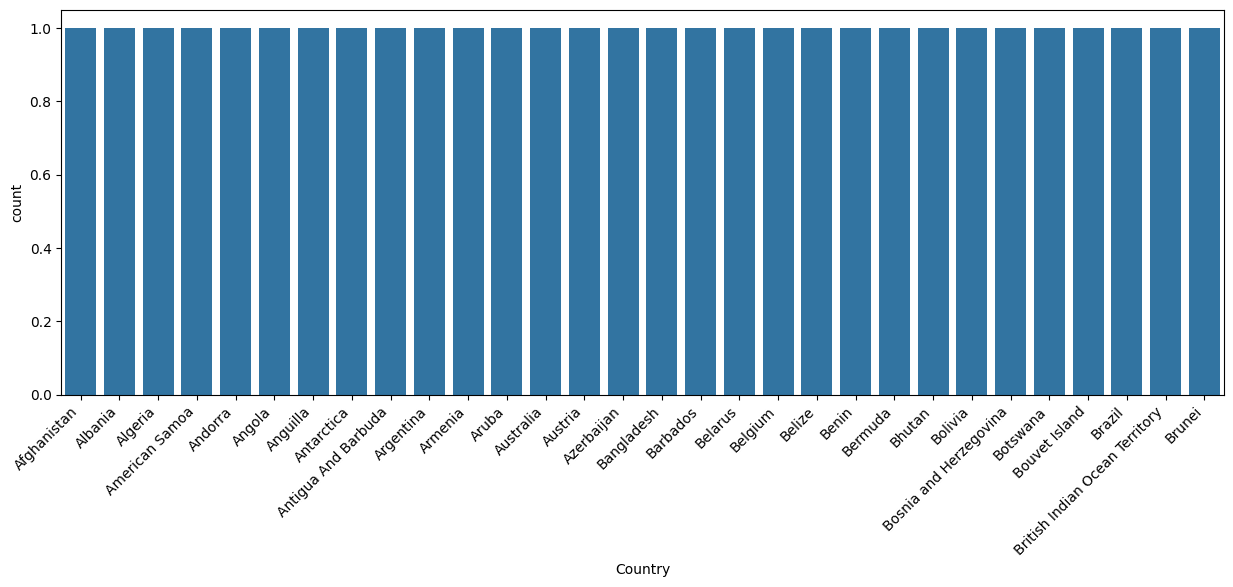

In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        fig_dims = (15, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()

cat_summary(df, "Country", plot=True)

count    30.000000
mean      3.666667
std       6.768759
min       1.000000
5%        1.000000
10%       1.000000
20%       1.000000
30%       1.000000
40%       1.000000
50%       1.000000
60%       1.000000
70%       2.000000
80%       2.200000
90%      10.200000
95%      16.400000
99%      28.520000
max      32.000000
Name: Quantity, dtype: float64


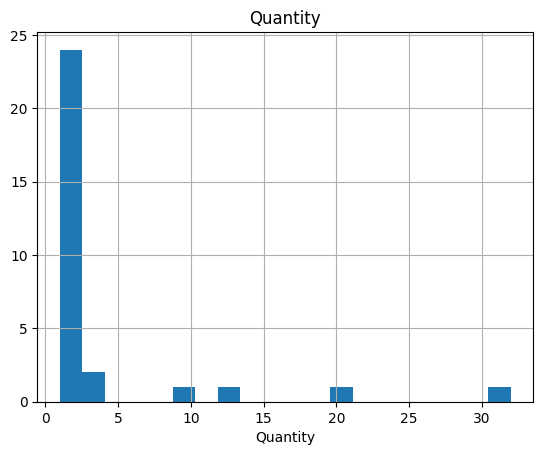

count      30.000000
mean       96.529103
std       202.408346
min         1.204819
5%          1.204819
10%         1.204819
20%         1.204819
30%         5.951808
40%        12.048190
50%        15.295180
60%        45.493974
70%       118.433740
80%       140.375900
90%       219.084360
95%       248.313225
99%       844.091314
max      1084.337000
Name: Price, dtype: float64


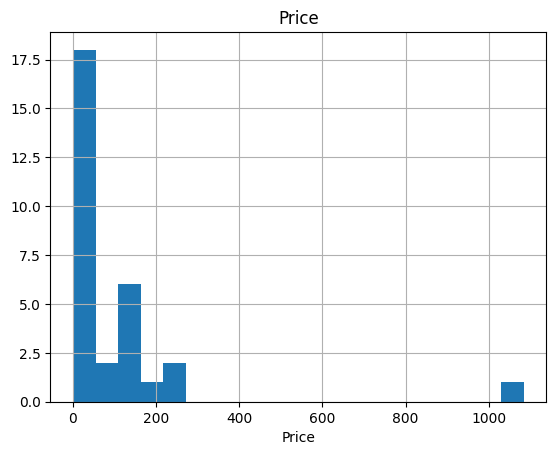

count       30.000000
mean     42983.666667
std      25006.073494
min          1.000000
5%           3.900000
10%          5.000000
20%      19113.800000
30%      23809.600000
40%      58484.600000
50%      60094.000000
60%      60096.000000
70%      60096.000000
80%      60097.000000
90%      60098.100000
95%      60099.000000
99%      60099.000000
max      60099.000000
Name: Customer ID, dtype: float64


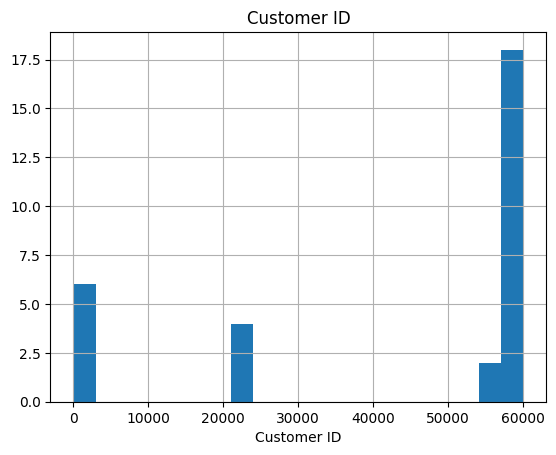

In [14]:

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [15]:
# How many sales for each product?
df_product = df.groupby("Description").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product

,Description,Quantity
0,56hj,1
1,AKFJJ,1
2,B.VOC MLT,1
3,Bid,1
4,CRM,1
5,IC Lm324,1
6,LI,1
7,LIC,1
8,Test,1
9,Ticket,1


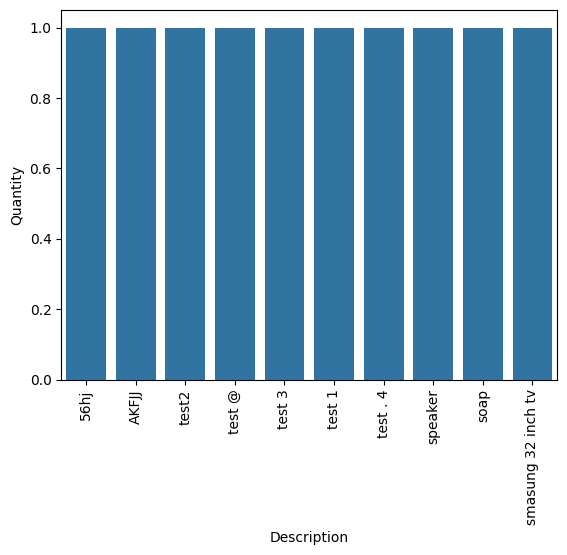

In [16]:
# Top 10 Products
top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)

sns.barplot(x="Description", y="Quantity", data=top_pr)
plt.xticks(rotation=90)
plt.show()

In [17]:
# total price per invoice
df["TotalPrice"] = df["Price"] * df["Quantity"]

In [18]:
# Determining the analysis date for the recency
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [19]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda InvıiceDate: (today_date- InvıiceDate.max()).days,
                                    "Invoice": lambda Invoice: Invoice.nunique(),
                                    "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,17.0,-3637.823529,188.727726,-4009.000000,-3689.000000,-3640.000000,-3640.00000,-3352.0000
frequency,17.0,1.117647,0.332106,1.000000,1.000000,1.000000,1.00000,2.0000
monetary,17.0,1102.681318,2206.085673,1.204819,1.204819,12.054219,808.24103,7649.1552


In [20]:
rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,17.0,-3637.823529,188.727726,-4009.000000,-3689.000000,-3640.000000,-3640.00000,-3352.0000
frequency,17.0,1.117647,0.332106,1.000000,1.000000,1.000000,1.00000,2.0000
monetary,17.0,1102.681318,2206.085673,1.204819,1.204819,12.054219,808.24103,7649.1552


In [21]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# frequency_score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# monetary_score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4], duplicates='drop')

#  RFM Score
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
1,-3640,1,1.204819,3,1,1,31
3,-3640,1,7.469880,3,1,1,31
5,-3640,1,2.409638,3,1,1,31
7,-3640,1,1.204819,3,1,1,31
429,-3641,1,1.204819,3,2,1,32
23785,-3642,2,12.054219,4,5,2,45
23790,-3380,1,1.204819,1,2,1,12
23818,-3411,1,1.204819,1,2,1,12
56077,-3640,1,55.590360,3,3,2,33


In [22]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
1,-3640,1,1.204819,3,1,1,31,about_to_sleep
3,-3640,1,7.469880,3,1,1,31,about_to_sleep
5,-3640,1,2.409638,3,1,1,31,about_to_sleep
7,-3640,1,1.204819,3,1,1,31,about_to_sleep
429,-3641,1,1.204819,3,2,1,32,about_to_sleep
23785,-3642,2,12.054219,4,5,2,45,loyal_customers
23790,-3380,1,1.204819,1,2,1,12,hibernating
23818,-3411,1,1.204819,1,2,1,12,hibernating
56077,-3640,1,55.590360,3,3,2,33,need_attention


In [23]:
# Let's group RFM mean and frequency values according to segments
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency           monetary      
                       mean count      mean count         mean count
segment                                                             
about_to_sleep      -3640.2     5      1.00     5     2.698795     5
at_Risk             -3352.0     2      1.00     2   150.602415     2
champions           -3872.0     4      1.25     4  2656.472768     4
hibernating         -3395.5     2      1.00     2     1.204819     2
loyal_customers     -3665.5     2      1.50     2    48.918669     2
need_attention      -3640.0     1      1.00     1    55.590360     1
potential_loyalists -3688.0     1      1.00     1  7649.155200     1

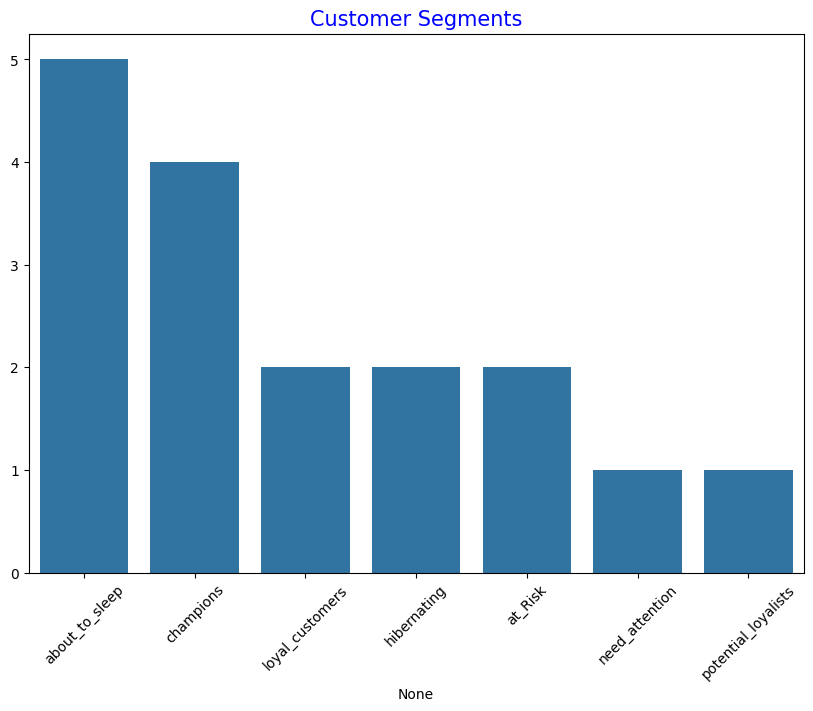

In [24]:
sgm= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

In [25]:
# Treemap Visualization
df_treemap = rfm.groupby('segment').agg('count').reset_index()
df_treemap.head()

,segment,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,about_to_sleep,5,5,5,5,5,5,5
1,at_Risk,2,2,2,2,2,2,2
2,champions,4,4,4,4,4,4,4
3,hibernating,2,2,2,2,2,2,2
4,loyal_customers,2,2,2,2,2,2,2


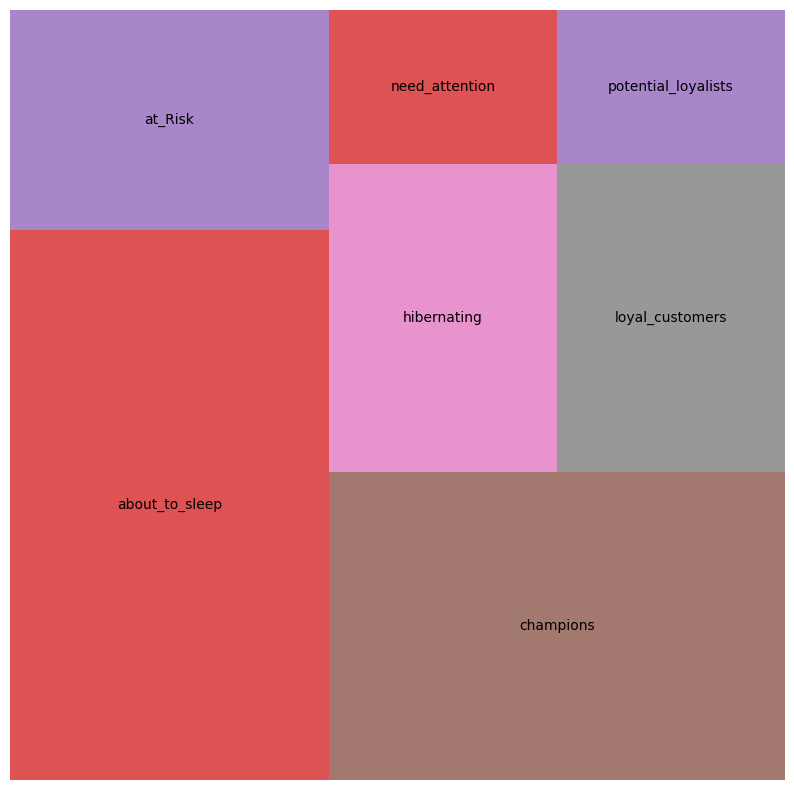

In [26]:
fig, ax = plt.subplots(1, figsize = (10,10))

squarify.plot(sizes=df_treemap['RFM_SCORE'],
              label=df_treemap['segment'],
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )
plt.axis('off')
plt.show()
#plt.savefig('treemap.png')

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [28]:
rfm_data = rfm[['recency', 'frequency', 'monetary']]

In [29]:
train_size = int(len(rfm_data) * 0.8)
train, test = rfm_data.iloc[:train_size], rfm_data.iloc[train_size:]

In [31]:
endog = train['monetary']
model = ARIMA(endog, order=(5, 1, 0))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [32]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['monetary'], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2222.287


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

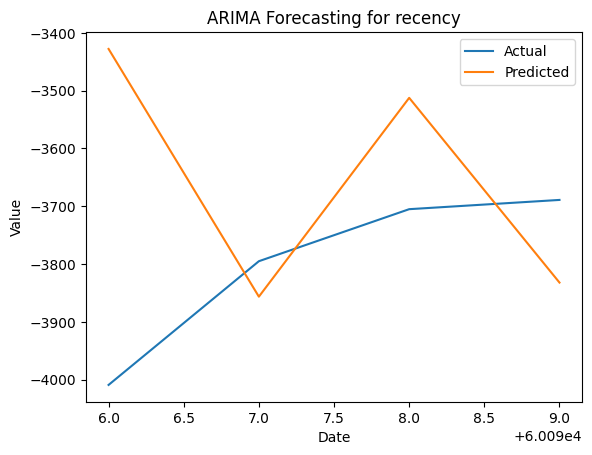

Test RMSE for recency: 315.86705702467043


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


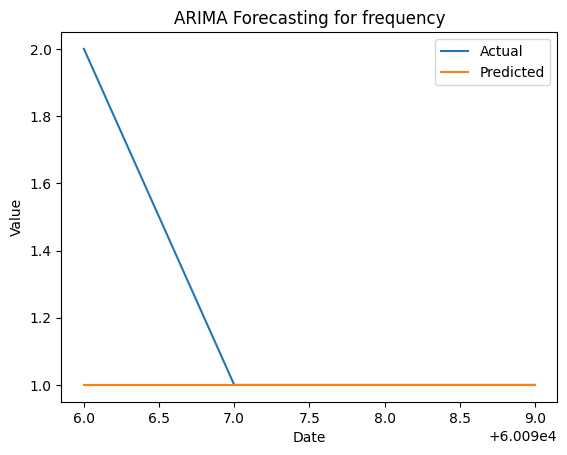

Test RMSE for frequency: 0.4999999999997945


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

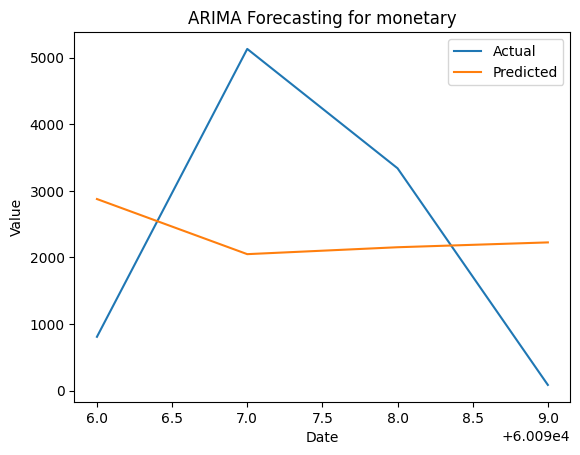

Test RMSE for monetary: 2222.287194693917


In [36]:
train_size = int(len(rfm) * 0.8)
train, test = rfm.iloc[:train_size], rfm.iloc[train_size:]

def arima_forecast(train, test, target_col):
    model = ARIMA(train[target_col], order=(5, 1, 0))
    model_fit = model.fit()

    predictions = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test[target_col], predictions))

    plt.plot(test.index, test[target_col], label='Actual')
    plt.plot(test.index, predictions, label='Predicted')
    plt.title(f'ARIMA Forecasting for {target_col}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    print(f'Test RMSE for {target_col}: {rmse}')

# Perform ARIMA forecasting for each column
for col in ['recency', 'frequency', 'monetary']:
    arima_forecast(train, test, col)

Test RMSE for recency: 0.0


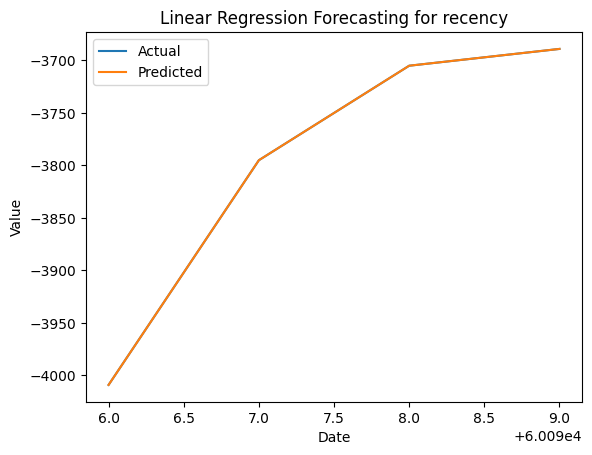

Test RMSE for frequency: 1.1102230246251565e-16


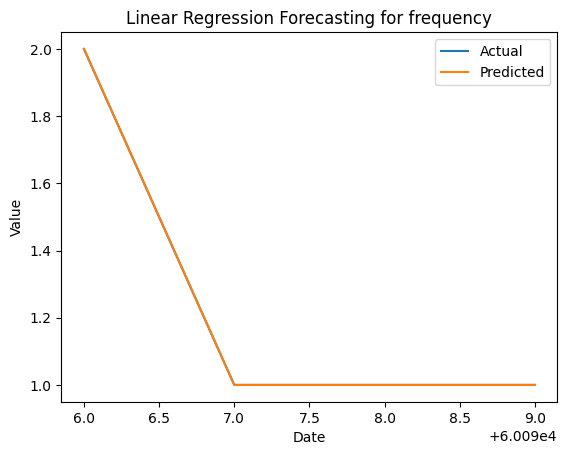

Test RMSE for monetary: 2178.8521903788173


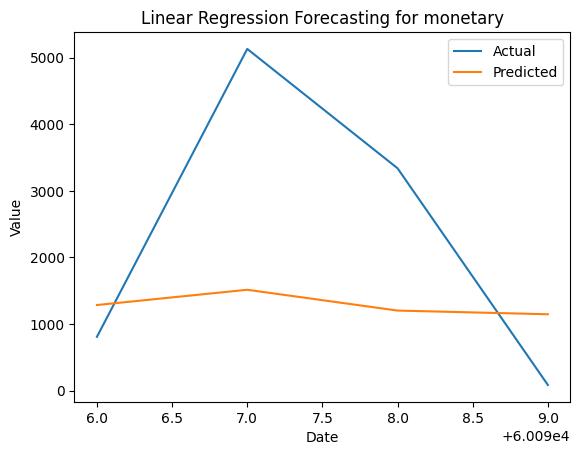

In [37]:
from sklearn.linear_model import LinearRegression

# Define a function for linear regression forecasting
def linear_regression_forecast(train, test, target_col):
    X_train = train[['recency', 'frequency']]
    y_train = train[target_col]

    X_test = test[['recency', 'frequency']]
    y_test = test[target_col]

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'Test RMSE for {target_col}: {rmse}')

    # Visualize the predictions
    plt.plot(test.index, y_test, label='Actual')
    plt.plot(test.index, predictions, label='Predicted')
    plt.title(f'Linear Regression Forecasting for {target_col}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Perform linear regression forecasting for each column
for col in ['recency', 'frequency', 'monetary']:
    linear_regression_forecast(train, test, col)
